### Forecasting Bike Share Usage

For this project I'll be using the Bike Sharing Dataset obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

The purpose of this project is to predict the hourly demand for rental bikes and provide suggestions on ways to increase revenue.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

/Users/nikitaroy/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Exploration & Preprocessing


The dataset contains the following 12 attibutes where each entry represents the data for one hour in a 24 hour day

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

In [4]:
bikes_df = pd.read_csv('bikes_df.csv')
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [5]:
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [6]:
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


Here we see that Washington, DC recorded a wide-range of temperatures spanning from 20.0 F to 100.0 F. The city is fairly humid with an average relative humidity of 62.7% and a standard deviation of 19.2. The average wind speed was 19 MPH; Fog and thunderstorms were rare but rain and snow occured more often. The temperature variable seems to have been normalized to range from 0 to 1, or else DC saw high of 100 degrees and a low of 0 degrees farenheight.

Also, after inspecting all the data types, most of the types make sense for the data stored however, dteday is stored as an object and should be converted to datetime.

In [7]:
# covert to datetime
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

<HR>
In order to help with the analysis, I am going to break down the dteday column into two additional columns: *month* and *year*. I am also going to create an additional column *counts* that sums up the total number of casual and registered bike readers in order to give us an idea of the total number of bikes rented per hour. 
<HR>

In [10]:
# function to assign 0 to 2011 and 1 to 2012

def encode_year(x):
    return np.int64(np.floor(x-2011))
   
    
# create `year` column
bikes_df.loc[:,'year'] = bikes_df.dteday.dt.year

# create `month` column
bikes_df.loc[:,'month'] = bikes_df.dteday.dt.month
   
# encode `year` column with 0 and 1
bikes_df['year'] = bikes_df['year'].apply(encode_year)

bikes_df['counts'] = bikes_df.casual+ bikes_df.registered

# re-organize the columns 
columns = ['dteday','hour','season', 'holiday', 'year','month','weekday', \
           'workingday','weather', 'temp', 'atemp', 'hum', 'windspeed', \
           'casual', 'registered', 'counts']
bikes_df = bikes_df.reindex(columns = columns)

In [11]:
bikes_df.head()

,dteday,hour,season,holiday,year,month,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts
0,2011-01-01,0,1,0,0,1,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,2,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,3,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,4,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Visualizing how casual rentals and registered rentals vary with the hour. 

In [12]:
# display times in more readable form
ticks_dict = {0: '12:00am', 2: "2:00am", 4: "4:00am", 6: "6:00am", 
              8: "8:00am", 10: '10:00am', 12: '12:00pm', 14: '2:00pm', 
              16:'4:00pm', 18:'6:00pm', 20:'8:00pm', 22:'10:00pm'}   


In [13]:
def get_hourly_violin_lists(bikes_data):

    reg_hourly_data = []
    cas_hourly_data = []
    for cur_hour in range(24):
        cur_registered = bikes_data.loc[bikes_data.hour==cur_hour,'registered'].values.reshape(-1,1)
        cur_casual = bikes_data.loc[bikes_data.hour==cur_hour,'casual'].values.reshape(-1,1)

        reg_hourly_data.append(cur_registered)
        cas_hourly_data.append(cur_casual)

    return reg_hourly_data,cas_hourly_data

In [14]:

mids = bikes_df.groupby("hour").median()[["registered","casual"]]


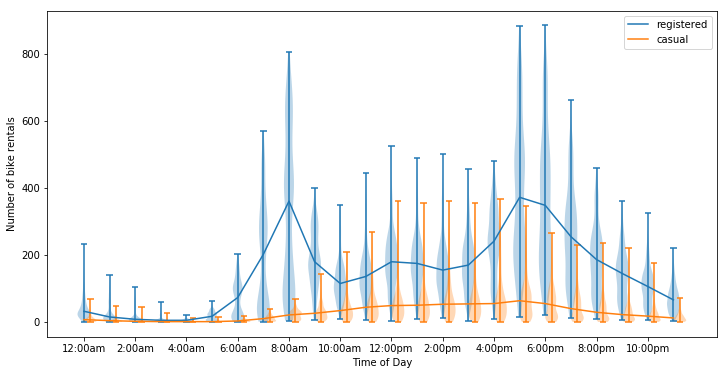

In [33]:
# scatterplot of  distribution of rentals during the day (blue is registered and red is casual)
reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df)

plt.figure(figsize=(12,6))
plt.xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
reg = plt.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
cas = plt.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)
plt.legend()

med = plt.plot(list(range(24)),mids["registered"].values,c = 'tab:blue', label="registered")
medb = plt.plot(list(range(24)),mids["casual"].values,c='tab:orange', label="casual")
plt.ylabel('Number of bike rentals')
plt.xlabel('Time of Day')
plt.legend()

plt.show()

Based on this plot, it appears that ridership follows a bimodal distribution with peaks corresponding to 8am and 5pm. Those peaks are those of registered riders during the afternoon rush hour, which is around 5:00pm, and during the morning commute, around 8:00am. This makes sense as people who use the bikes to go to work tend to buy season passes. 

We also notice smaller peaks throughout the day, such as around midnight when people maybe come back from a night out. 

Casual ridership follows the same distribution with the **notable absence** of the two large peaks.

#### Observing the effect of holidays on bike ridership

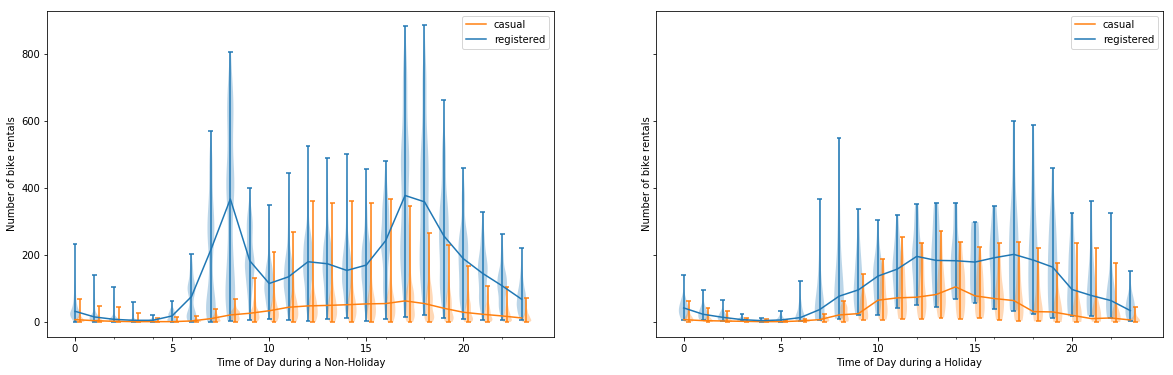

In [32]:
# scatterplot of rentals during a holiday (blue is registered and red is casual)


fig, ax = plt.subplots(1,2, figsize=(20,6),sharey=True)

for cur_holiday in (0,1):
    cur_ax = ax[cur_holiday]
    
    # group data by hour
    bikes_df_holiday = bikes_df[(bikes_df.holiday == cur_holiday)]
    reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df_holiday)

    # get medians
    reg_hourly_data_meadian= [np.median(q) for q in reg_hourly_data]
    cas_hourly_data_meadian= [np.median(q) for q in cas_hourly_data]
    
    # plot distribution at each hour
    reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
    cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)

    cur_ax.plot(cas_hourly_data_meadian, 'tab:orange', label="casual")
    cur_ax.plot(reg_hourly_data_meadian, 'tab:blue', label="registered")
    
    cur_ax.set_xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
    cur_ax.set_ylabel('Number of bike rentals')
    if cur_holiday == 1:
        cur_ax.set_xlabel('Time of Day during a Holiday')
    else:
        cur_ax.set_xlabel('Time of Day during a Non-Holiday')
    cur_ax.legend()
    
plt.show()

As expected, here we can that overall there are lower numbers during holidays.

However, there is an interesting pattern such that still appears to be scattered points at the two rush hour peaks. This might indicate days when it is in fact a holiday however, people still need to be at work. 

#### Looking at the relationship between weather and type of bike rental

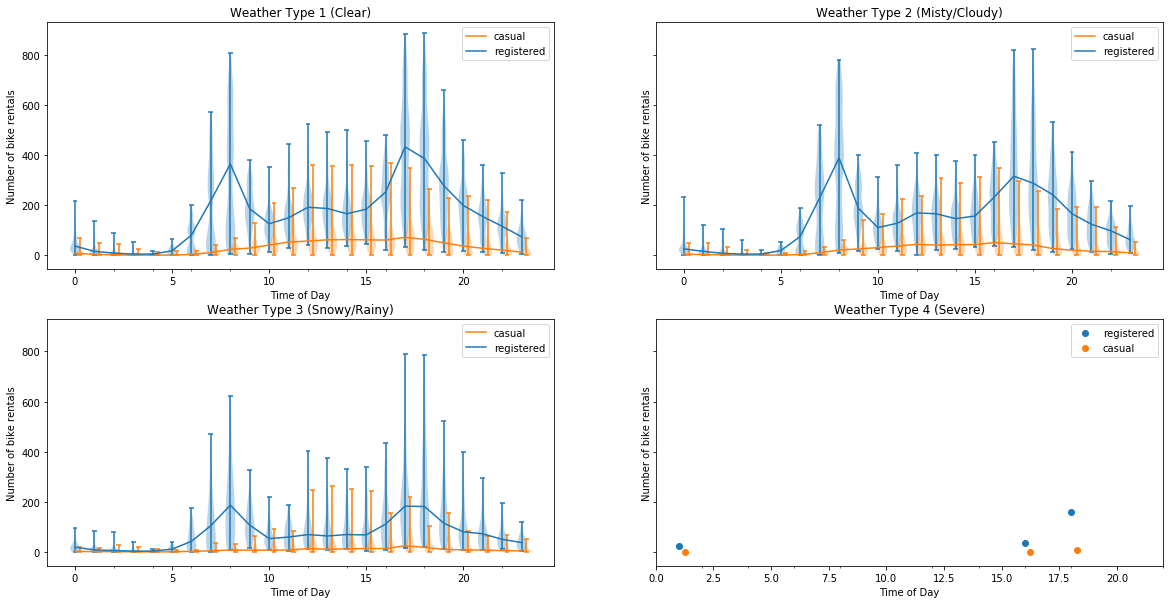

In [31]:
fig, ax = plt.subplots(2,2, figsize=(20,10), sharey=True)
ax = ax.ravel()

weather_strings = ["Clear", "Misty/Cloudy", "Snowy/Rainy", "Severe"]
for cur_weather in range(1,5):
    cur_ax = ax[cur_weather-1]
    cur_weather_string = weather_strings[cur_weather-1]
    
    bikes_df_weather = bikes_df[(bikes_df.weather == cur_weather)]
    
    
    if cur_weather == 4:
        # for blizard weather we have maximum one data point per hour, and often none
        # so just usign scatter plot the data
        reg = cur_ax.scatter(bikes_df_weather['hour'].values, bikes_df_weather['registered'].values, label="registered")
        cas = cur_ax.scatter(bikes_df_weather['hour'].values+.25, bikes_df_weather['casual'].values, label="casual")
    else:
        #for most weathers, plotting the distribution and median at each hour
        reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df_weather)
        reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
        cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)
        
        reg_hourly_data_meadian= [np.median(q) for q in reg_hourly_data]
        cas_hourly_data_meadian= [np.median(q) for q in cas_hourly_data]
        cur_ax.plot(cas_hourly_data_meadian, 'tab:orange', label="casual")
        cur_ax.plot(reg_hourly_data_meadian, 'tab:blue', label="registered")
        
    cur_ax.legend()
    
    cur_ax.set_xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
    cur_ax.set_ylabel('Number of bike rentals')
    cur_ax.set_xlabel('Time of Day')
    cur_ax.set_title('Weather Type {} ({})'.format(cur_weather, cur_weather_string))
    

Weather seems to have an effect mostly on casual rentals and this is probably because the registered riders go to work and they do so in all weather. Casuals, on the other hand, which tend to use their bikes for leisure, probably prefer good weather.

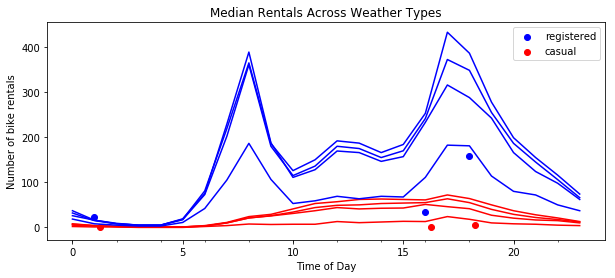

In [34]:
# Investigating the claim above by looking at the median bike rental in all weathers 
fig, ax = plt.subplots(1,1, figsize=(10,4), sharey=True)


alpha_vals = [.01,.01,.1,1]
weather_strings = ["Clear", "Misty/Cloudy", "Snowy/Rainy", "Severe"]
for cur_weather in range(1,5):
    cur_ax = ax
    cur_alpha = alpha_vals[cur_weather-1]
    cur_weather_string = weather_strings[cur_weather-1]
    
    bikes_df_weather = bikes_df[(bikes_df.weather == cur_weather)]
    
    
    reg_hourly_data_meadian= [np.median(q) for q in reg_hourly_data]
    cas_hourly_data_meadian= [np.median(q) for q in cas_hourly_data]
    cur_ax.plot(cas_hourly_data_meadian, 'r')
    cur_ax.plot(reg_hourly_data_meadian, 'b')
    
    
    
    if cur_weather == 4:
        reg = cur_ax.scatter(bikes_df_weather['hour'].values, bikes_df_weather['registered'].values, alpha=cur_alpha, label="registered", color = 'b')
        cas = cur_ax.scatter(bikes_df_weather['hour'].values+.25, bikes_df_weather['casual'].values, alpha=cur_alpha, label="casual", color = 'r')
        cur_ax.legend()
    else:
        reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df_weather)
        #reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
        #cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)
    
    cur_ax.set_xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
    cur_ax.set_ylabel('Number of bike rentals')
    cur_ax.set_xlabel('Time of Day')
    cur_ax.set_title('Median Rentals Across Weather Types')


After looking at this plot, I think the previous claim is totally unsubstantiated. It appears that there is no substantial difference depending on the weather. 

<HR>
## Exploring Seasonality on Bike Ridership
<HR>


In [39]:
bikes_by_day = bikes_df.copy()

In [40]:
# Grouping by day and aggregate counts for scatterplot of season against counts
bikes_by_day = bikes_by_day[['dteday', 'weather', 'season', 'windspeed', 'temp', 'atemp', 'hum', 
                      'weekday', 'casual', 'registered', 'counts']].groupby('dteday').agg({'counts' : np.sum,
                                                                                 'casual' : np.sum,
                                                                                 'weather': np.max,
                                                                                 'registered' : np.sum,
                                                                                 'season' : np.mean,
                                                                                 'weekday' : np.mean,
                                                                                 'windspeed': np.mean,
                                                                                 'temp' : np.mean,
                                                                                 'atemp' : np.mean,
                                                                                 'hum' : np.mean})
bikes_by_day.head(5)

,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
dteday,,,,,,,,,,
2011-01-01,985,331,3,654,1,6,0.160446,0.344167,0.363625,0.805833
2011-01-02,801,131,3,670,1,0,0.248539,0.363478,0.353739,0.696087
2011-01-03,1349,120,1,1229,1,1,0.248309,0.196364,0.189405,0.437273
2011-01-04,1562,108,2,1454,1,2,0.160296,0.200000,0.212122,0.590435
2011-01-05,1600,82,1,1518,1,3,0.186900,0.226957,0.229270,0.436957


In [45]:
# scatterplot of season against ridership
def plot_season(data, ylabel):
    
    plt.ylabel(ylabel)
    plt.xlabel('Season')
    plt.yticks([0.0, 2.0, 4.0, 6.0, 8.0])  
    plt.xticks([1.0, 2.0, 3.0, 4.0],
               ["winter", "spring", "summer", "fall"])
    plt.scatter(data['season'].values, data['casual'].values/1000, alpha=0.1 , c='r', label="casual")
    plt.scatter(data['season'].values+.15, data['registered'].values/1000, alpha=0.1 , c='b', label="registered")
    
    plt.legend()
    return plt.show()

plt.style.use('ggplot')

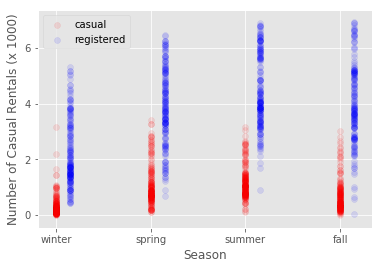

In [46]:
# scatterplot of season vs casual rentals 
plot_season(bikes_by_day, 'Number of Casual Rentals (x 1000)')

There is an overall trend for more bike use in the spring and summer but we see variation among the two categories of riders. We see that winter is a period with very low rentals by casual riders and that makes sense because these are probably recreational users that do not like to ride in bad weather. One the other hand, winter is high on registered users because they probably use the bikes to go to work. Fall is another low period for casual riders and the highest for registered users because fall is work season with good weather generally.

#### Exploring the percentage of rentals made by casual riders or registered riders 

In [50]:
days_of_week = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 
                3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday',}

In [51]:
# find the casual riders

weekday_casual_counts = bikes_by_day[['weekday','casual','registered','counts']].\
                        copy().groupby('weekday').aggregate(sum)
n = weekday_casual_counts['counts']
weekday_casual_counts['casual'] = round((weekday_casual_counts['casual']/n*100),2)
weekday_casual_counts['registered'] = round((weekday_casual_counts['registered']/n*100),2)
weekday_casual_counts['counts'] = 100

weekday_casual_counts = weekday_casual_counts.rename(days_of_week)  # rename index for readability
weekday_casual_counts

,casual,registered,counts
weekday,,,
Sunday,31.65,68.35,100
Monday,15.54,84.46,100
Tuesday,12.33,87.67,100
Wednesday,12.12,87.88,100
Thursday,12.66,87.34,100
Friday,16.04,83.96,100
Saturday,32.20,67.80,100


We see a trend for more registered riders during the week: 84% registered on a Monday vs. 15% casual on the same day, 87% on Tuesday vs. 12% casual. We notice that registered riders use their bikes to go to work and also ride during the weekend in about 25% less frequency. Casual riders, as expected, ride mostly during Saturdays and Sundays with a large decline during the working week.
    
<HR>

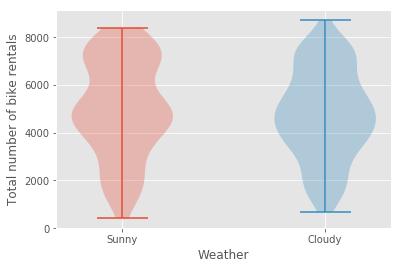

In [52]:
plt.violinplot(bikes_by_day.loc[bikes_by_day.weather==1,'counts'],positions=[1])
plt.violinplot(bikes_by_day.loc[bikes_by_day.weather==2,'counts'],positions=[2])

plt.xlabel("Weather")
plt.xticks([1,2], ["Sunny","Cloudy"])
plt.ylabel("Total number of bike rentals")
plt.show()

On sunny days, ridership is bimodal, at around either 5000 total rentals or 7500 total rentals. When cloudy, the upper peak fades, and the sole mode is at 5000 rentals. However, 7500 rentals is still perfectly possible on a cloudy day.

#### Exploring how the total number of daily rentals is affected by season

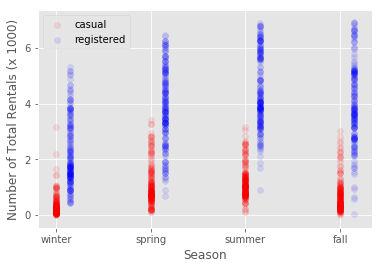

In [53]:
# scatterplot of season vs total rentals 
plot_season(bikes_by_day, 'Number of Total Rentals (x 1000)')

In [54]:
# trying to find outlier of variable var_of_interest for given season s
def find_outlier(s, var_of_interest, data):
    season_df = data[data.season == s]
    
    raw_data = season_df.loc[:,var_of_interest]
    q1 = np.percentile(raw_data,25)
    q3 = np.percentile(raw_data,75)
    IQR = q3 - q1
    
    upper_bound = q3 + 1.5*IQR 
    lower_bound = q1 - 1.5*IQR 
    
    outliers_flag = np.logical_or(raw_data>upper_bound, raw_data<lower_bound)
    
    if np.sum(outliers_flag) == 0:
        print ('no outliers found')
        return None
    else:
        return season_df.loc[outliers_flag]
    

In [57]:
# Total count outliers for winter
find_outlier(1, 'counts', bikes_by_day)

,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
dteday,,,,,,,,,,
2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833


In [58]:
# Total count outliers for spring
find_outlier(2, 'counts', bikes_by_day) 

no outliers found


In [59]:
# Total count outliers for summer
find_outlier(3, 'counts', bikes_by_day)  

no outliers found


In [60]:
# Total count outliers for fall
find_outlier(4, 'counts', bikes_by_day) 

,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
dteday,,,,,,,,,,
2012-10-29,22,2,3,20,4,1,0.3582,0.44,0.4394,0.88


<HR>
We see that the total number of rentals tends to be smaller in the winter (season 1) which makes sense. It then increases in spring, peaks in summer and starts falling again in fall but not as much as in winter.

We observe that there is a value during the winter that is much higher that the others. This is our outlier. A search in the dataframe shows that this high value for bike rentals occurs on 2012-03-17. A web search for that date shows that it was **St. Patrick's Day**! So it can be concurred that this is a real observation.

During the summer we see that 2011-08-27 is unusually low and it was the day of Hurricane Irene! However that point does not show as an outlier in the boxplots, maybe because of the actual high count (1115) indicating that probably the effects of the hurricane in the region was not as severe

The outlier for Fall is 2012-10-29. We observe that only 22 rides were rented on 2012-10-29. Once again upon conducting a web search for that date it shows that it was during **Hurricane Sandy**! 
<HR>

### Preparing Data for Regression

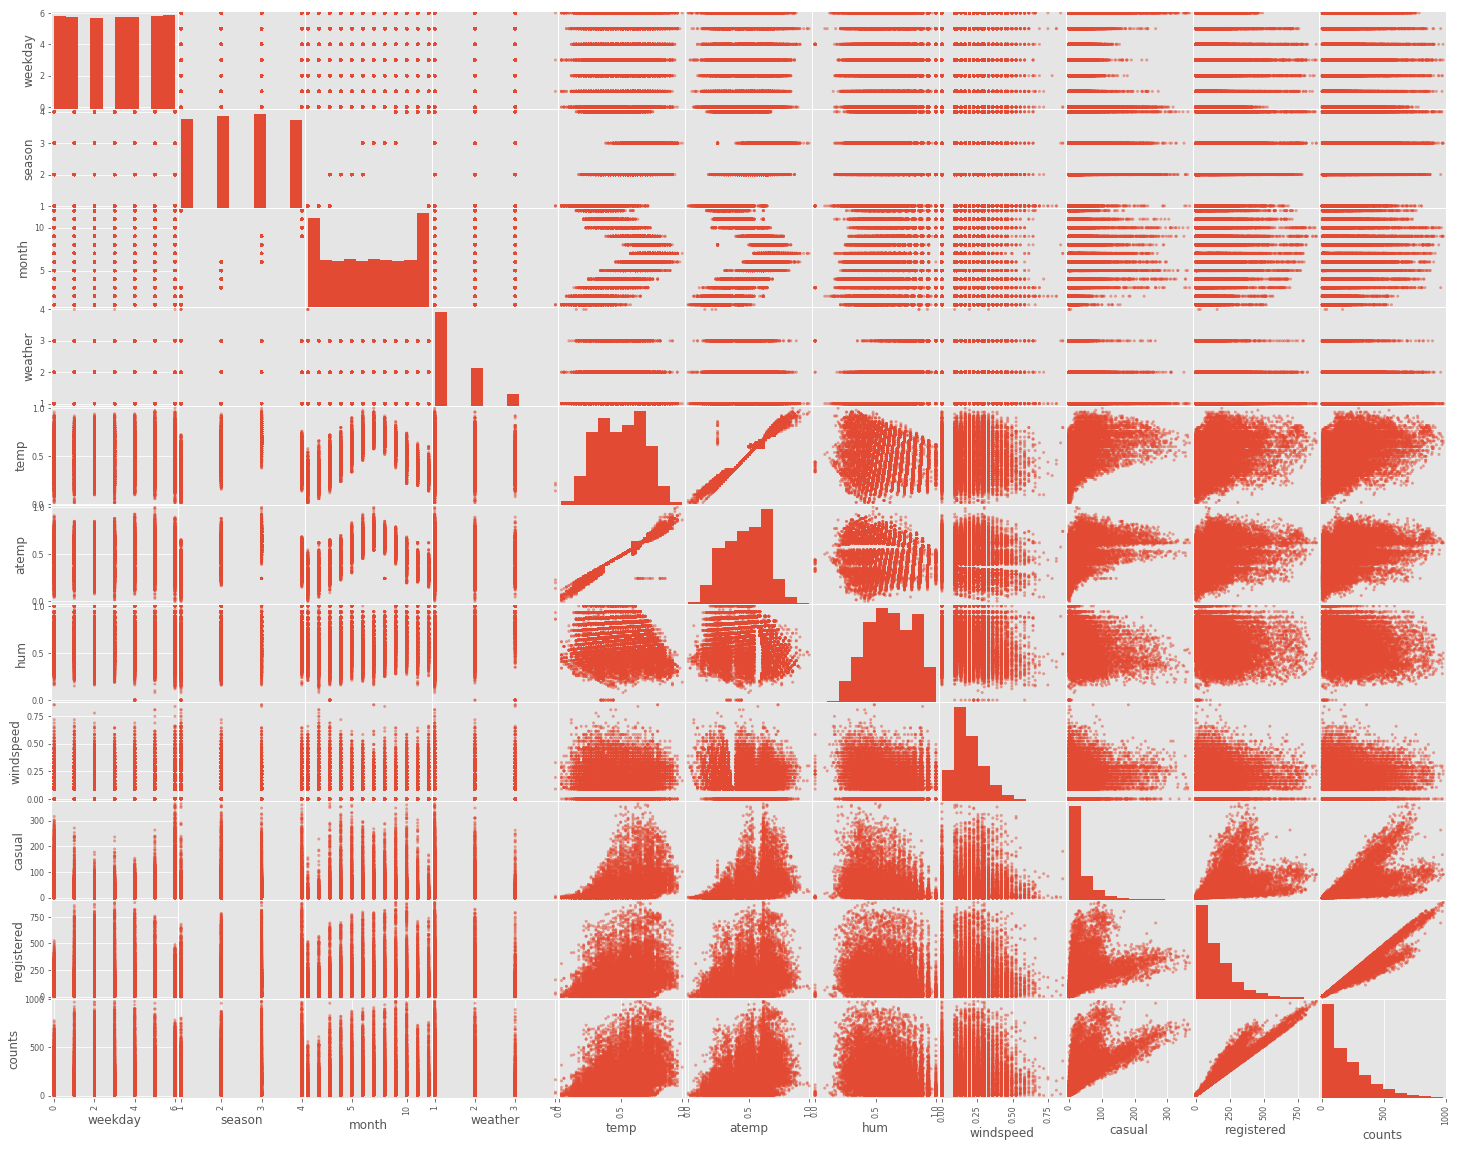

In [61]:
# make combinations of features
cols_wanted = ['weekday', 'season', 'month',
       'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'counts']

scatter_matrix(bikes_df[cols_wanted], alpha=0.5, figsize=(25,20));

We see a clear linear dependency between total counts and temperature (both `temp` and `atemp` variables). We also notice that `atemp` and `temp` are nearly perfectly correlated. `month` and `season` are also obviously conveying the same information.

`registered` and `counts` are likewise correlated.

#### Converting categorical attributes  into binary variables using one-hot encoding

In [62]:
# saving the pre-recoding bikes data
bikes_df_raw = bikes_df.copy()

In [63]:
categorical_columns = ['season', 'month', 'holiday', 'weekday', 'workingday', 'weather']
categorical_columns_g2cols = ['season', 'month', 'weekday', 'weather']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts']

bikes_df = pd.get_dummies(bikes_df, columns=categorical_columns_g2cols, drop_first=True)

In [64]:
bikes_df.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [65]:
# creating more meaningful names to the one-hot encoded variables
seasons = {'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall',}
months = {'month_2': 'Feb', 'month_3': 'Mar', 'month_4': 'Apr',
       'month_5':'May', 'month_6': 'Jun', 'month_7': 'Jul', 'month_8': 'Aug', 'month_9': 'Sept', 'month_10': 'Oct',
       'month_11': 'Nov', 'month_12': 'Dec', }
weekdays = {'weekday_1': 'Mon', 'weekday_2': 'Tue', 'weekday_3': 'Wed',
       'weekday_4': 'Thu', 'weekday_5': 'Fri', 'weekday_6': 'Sat'}
weather = {'weather_2': 'Cloudy', 'weather_3': 'Snow', 'weather_4': 'Storm'}

combined_renamer = {**seasons, **months, **weekdays, **weather}

In [66]:
bikes_df = bikes_df.rename(columns=combined_renamer)

In [67]:
bikes_df.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


#### Splitting the initial bikes_df dataset into train and test set

In [68]:
### split in train and test but still keeping equal representation of each on month in train and test
bikes_train, bikes_test = train_test_split(bikes_df, test_size=.2, stratify=bikes_df_raw['month'])

In [69]:
bikes_train.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
1654,2011-03-14,12,0,0,1,0.38,0.3939,0.37,0.0000,40,...,0,1,0,0,0,0,0,0,0,0
15126,2012-09-27,11,0,1,1,0.72,0.6667,0.51,0.1642,67,...,0,0,0,0,1,0,0,1,0,0
1923,2011-03-25,22,0,0,1,0.28,0.2576,0.38,0.3284,3,...,0,0,0,0,0,1,0,1,0,0
11922,2012-05-16,23,0,1,1,0.62,0.5909,0.78,0.1045,26,...,0,0,0,1,0,0,0,0,0,0
10319,2012-03-11,1,0,1,0,0.24,0.2424,0.52,0.1642,4,...,0,0,0,0,0,0,0,0,0,0


In [70]:
bikes_test.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
10510,2012-03-19,1,0,1,1,0.46,0.4545,0.88,0.1045,0,...,0,1,0,0,0,0,0,0,0,0
475,2011-01-21,20,0,0,1,0.10,0.0758,0.33,0.4179,1,...,0,0,0,0,0,1,0,0,0,0
12394,2012-06-05,15,0,1,1,0.58,0.5455,0.46,0.1343,54,...,0,0,1,0,0,0,0,1,0,0
13998,2012-08-11,11,0,1,0,0.74,0.6970,0.66,0.1642,203,...,0,0,0,0,0,0,1,0,0,0
970,2011-02-13,1,0,0,0,0.20,0.2273,0.59,0.0896,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Removing dteday as its format can't be used, casual and registered are redundant since we include count variable
bikes_train = bikes_train.drop(['dteday','casual','registered'], axis=1)

bikes_test = bikes_test.drop(['dteday','casual','registered'], axis=1)

In [74]:
bikes_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
1654,12,0,0,1,0.38,0.3939,0.37,0.0000,94,0,...,0,1,0,0,0,0,0,0,0,0
15126,11,0,1,1,0.72,0.6667,0.51,0.1642,294,0,...,0,0,0,0,1,0,0,1,0,0
1923,22,0,0,1,0.28,0.2576,0.38,0.3284,43,1,...,0,0,0,0,0,1,0,1,0,0
11922,23,0,1,1,0.62,0.5909,0.78,0.1045,133,1,...,0,0,0,1,0,0,0,0,0,0
10319,1,0,1,0,0.24,0.2424,0.52,0.1642,61,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
bikes_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
10510,1,0,1,1,0.46,0.4545,0.88,0.1045,15,0,...,0,1,0,0,0,0,0,0,0,0
475,20,0,0,1,0.10,0.0758,0.33,0.4179,53,0,...,0,0,0,0,0,1,0,0,0,0
12394,15,0,1,1,0.58,0.5455,0.46,0.1343,272,1,...,0,0,1,0,0,0,0,1,0,0
13998,11,0,1,0,0.74,0.6970,0.66,0.1642,499,0,...,0,0,0,0,0,0,1,0,0,0
970,1,0,0,0,0.20,0.2273,0.59,0.0896,24,0,...,0,0,0,0,0,0,0,0,0,0


#### Identifying collinearity in the dataset

In [76]:
# Find all correlations 
corr = bikes_train.corr()
corr

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
hour,1.000000,0.004717,-0.002958,0.000742,0.138161,0.135476,-0.274441,0.132729,0.397215,0.002732,...,0.002126,0.005970,0.008069,-0.007510,-0.002215,-0.001006,-0.006320,-0.048280,0.019105,0.000270
holiday,0.004717,1.000000,0.004980,-0.248553,-0.021006,-0.024334,-0.011676,0.004161,-0.028203,-0.026602,...,0.001409,0.281774,-0.048216,-0.048300,-0.022119,-0.022379,-0.069980,-0.000801,-0.021667,-0.002489
year,-0.002958,0.004980,1.000000,-0.004558,0.041039,0.038844,-0.084307,-0.005404,0.251885,-0.005555,...,-0.005133,0.001820,0.004350,-0.001102,-0.004983,-0.003771,-0.003171,0.013995,-0.032775,0.004799
workingday,0.000742,-0.248553,-0.004558,1.000000,0.051419,0.050264,0.021763,-0.009993,0.025663,0.012059,...,-0.008696,0.152897,0.267884,0.271946,0.259472,0.263293,-0.605866,0.029649,0.033259,-0.000507
temp,0.138161,-0.021006,0.041039,0.051419,1.000000,0.987628,-0.071397,-0.014547,0.410187,0.144766,...,-0.274039,-0.005835,0.023986,0.015253,0.027095,-0.001684,-0.035022,-0.068680,-0.059495,-0.023645
atemp,0.135476,-0.024334,0.038844,0.050264,0.987628,1.000000,-0.054543,-0.052880,0.406703,0.152616,...,-0.265628,-0.001188,0.025967,0.013329,0.027661,-0.009979,-0.036266,-0.066582,-0.065823,-0.024668
hum,-0.274441,-0.011676,-0.084307,0.021763,-0.071397,-0.054543,1.000000,-0.287499,-0.323210,-0.005146,...,0.066717,0.021772,0.029808,0.037601,-0.038892,-0.026743,-0.017475,0.213564,0.309097,0.019547
windspeed,0.132729,0.004161,-0.005404,-0.009993,-0.014547,-0.052880,-0.287499,1.000000,0.094636,0.063233,...,-0.035282,-0.000008,0.006610,-0.013088,0.010054,-0.014680,0.021582,-0.046319,0.071979,0.001649
counts,0.397215,-0.028203,0.251885,0.025663,0.410187,0.406703,-0.323210,0.094636,1.000000,0.062123,...,-0.081019,-0.014834,0.008788,0.005945,0.012647,0.008360,-0.001469,-0.048893,-0.122276,-0.009368
spring,0.002732,-0.026602,-0.005555,0.012059,0.144766,0.152616,-0.005146,0.063233,0.062123,1.000000,...,-0.178150,0.009863,0.003766,-0.000379,-0.000896,-0.008737,-0.002532,-0.002718,0.015014,-0.008570


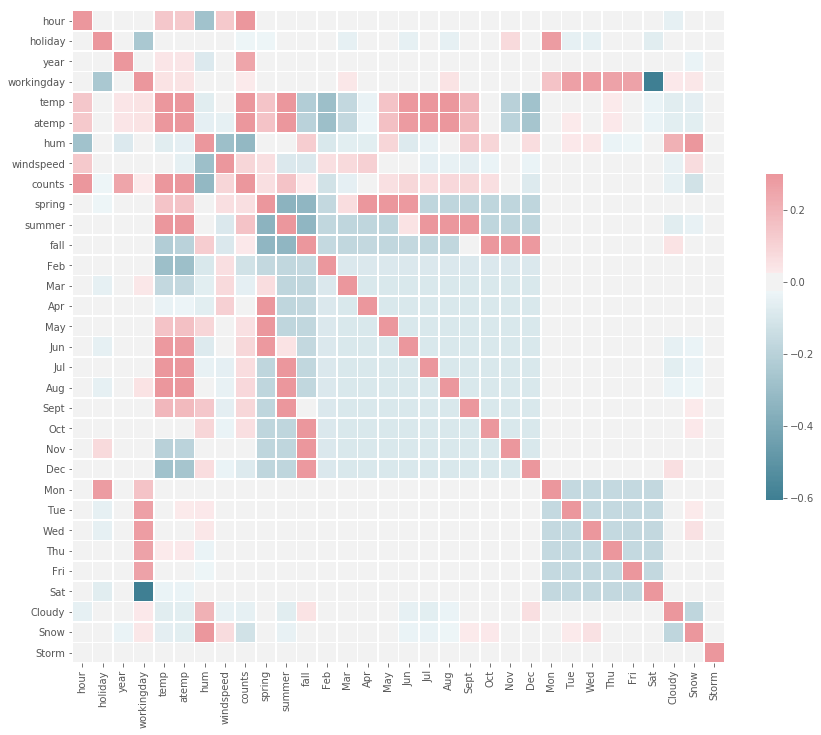

In [77]:
# Setting up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generating a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .5});

It can be seen here that there are a number of highly co-linear predictors.

In [78]:
# Iterating over the pairs of indexes to enumerate which pairs are highly correlated

print("Unique variables with absolute correlations > .7:")
for row_name in corr.index:
    for col_name in corr.index:
        # col_name < row_name excludes correlations between a variable
        # and itself, as well as repeat pairings.
        if np.abs(corr.loc[row_name,col_name])> .7 and col_name < row_name:
            print("(",row_name,",",col_name,")")

Unique variables with absolute correlations > .7:
( temp , atemp )


<HR>

There are a number of highly co-linear predictors.  Seasons tend to correlate with temperatures.  Working days tend to correlate with days of the week.  Different weather statuses tend to strongly negatively correlate.  The only distinct variables which had a correlation with magnitude greater than .7 was temp and average temp.  As to be expected, these are strongly correlated (with correlation roughly .98).

<HR>

### Building a Multiple Linear Regression Model to Predict the Hourly Bike Rental

In [79]:
# multiple linear regression
X_train = sm.add_constant(bikes_train.drop('counts', axis=1))
X_test = sm.add_constant(bikes_test.drop('counts', axis=1))
Y_train = bikes_train['counts'].values.reshape(-1,1)
Y_test = bikes_test['counts'].values.reshape(-1,1)

model = OLS(Y_train, X_train)
results = model.fit()

y_hat_train = results.predict()
y_hat_test = results.predict(exog=X_test)

print('Parameters: \n', results.params)

Parameters: 
 const         -25.620483
hour            7.338562
holiday       -22.001470
year           79.346015
workingday      9.782620
temp          308.034849
atemp         121.361080
hum          -203.717908
windspeed      22.723633
spring         43.550721
summer         22.833600
fall           64.617065
Feb           -11.865281
Mar           -14.933280
Apr           -45.995337
May           -38.610557
Jun           -73.083962
Jul           -94.791168
Aug           -58.413901
Sept          -12.405029
Oct           -13.112120
Nov           -26.681684
Dec           -10.958515
Mon            -4.568919
Tue            -2.885011
Wed             1.283942
Thu            -5.726970
Fri            -0.321893
Sat            11.120568
Cloudy          5.299912
Snow          -25.249111
Storm          47.439283
dtype: float64


In [80]:
# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(results.rsquared))
print('Test R^2 = {:.4}'.format(r2_score(bikes_test['counts'], y_hat_test)))

Train R^2 = 0.4127
Test R^2 = 0.38


In [81]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     324.9
Date:                Sat, 23 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:21:34   Log-Likelihood:                -88435.
No. Observations:               13903   AIC:                         1.769e+05
Df Residuals:                   13872   BIC:                         1.772e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.6205      8.653     -2.961      0.003     -42.581      -8.660
hour           7.3386      0.186     39.349      0.000       6.973       7.704
holiday      -22.0015      6.796     -3.237      0.001     -35.323      -8.680
year          79.3460      2.400     33.065      0.000      74.642      84.050
workingday     9.7826      2.790      3.507      0.000       4.314      15.251
temp         308.0348     44.866      6.866      0.000     220.091     395.979
atemp        121.3611     46.955      2.585      0.010      29.324     213.398
hum         -203.7179      7.837    -25.994      0.000    -219.079    -188.356
windspeed     22.7236     10.839      2.097      0.036       1.478      43.969
spring        43.5507      7.501      5.806      0.000      28.848      58.254
summer        22.8336      8.894      2.567      0.010       5.400      40.267
fall          64.6171      7.541      8.569      0.000      49.837      79.398
Feb          -11.8653      6.035     -1.966      0.049     -23.695      -0.036
Mar          -14.9333      6.724     -2.221      0.026     -28.113      -1.753
Apr          -45.9953     10.009     -4.595      0.000     -65.614     -26.376
May          -38.6106     10.676     -3.617      0.000     -59.537     -17.684
Jun          -73.0840     10.847     -6.738      0.000     -94.345     -51.823
Jul          -94.7912     12.203     -7.768      0.000    -118.711     -70.872
Aug          -58.4139     11.966     -4.882      0.000     -81.869     -34.959
Sept         -12.4050     10.711     -1.158      0.247     -33.401       8.591
Oct          -13.1121      9.953     -1.317      0.188     -32.621       6.397
Nov          -26.6817      9.611     -2.776      0.006     -45.521      -7.842
Dec          -10.9585      7.648     -1.433      0.152     -25.950       4.033
Mon           -4.5689      3.004     -1.521      0.128     -10.457       1.319
Tue           -2.8850      3.257     -0.886      0.376      -9.269       3.499
Wed            1.2839      3.231      0.397      0.691      -5.050       7.618
Thu           -5.7270      3.224     -1.776      0.076     -12.046       0.592
Fri           -0.3219      3.200     -0.101      0.920      -6.595       5.951
Sat           11.1206      4.430      2.510      0.012       2.438      19.803
Cloudy         5.2999      2.911      1.820      0.069      -0.407      11.006
Snow         -25.2491      4.896     -5.158      0.000     -34.845     -15.653
Storm         47.4393     81.117      0.585      0.559    -111.560     206.439
==============================================================================
Omnibus:                     2755.735   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5402.364
Skew:                           1.203   Prob(JB):                         0.00
Ku

In [82]:
results.pvalues[((results.pvalues < 0.005) & (results.params > 0))]

hour           0.000000e+00
year          7.748536e-231
workingday     4.553552e-04
temp           6.900993e-12
spring         6.538840e-09
fall           1.150613e-17
dtype: float64

In [83]:
results.pvalues[((results.pvalues < 0.005) & (results.params < 0))]

const       3.071761e-03
holiday     1.209378e-03
hum        1.695677e-145
Apr         4.356845e-06
May         2.995176e-04
Jun         1.669172e-11
Jul         8.538731e-15
Aug         1.063571e-06
Snow        2.536450e-07
dtype: float64

<HR>

The statistically significant variables with positive correlation: hour, year, workingday, temp, spring, summer, fall, Sat.

The statistically significant variables with negative correlation: the intercept, hum, Apr, May, Jun, Jul, Aug, Snow.

Most of these variables display a clear connection to factors reasonably believed to influence if someone would go biking, namely, temperature, humidity, weather, time of day, and day of the week.  In some cases, those particular variables are literally in our list of statistically siginificant variables.  In most of the remaining cases, the variable appears to heavily influence the preceding factors.

Year is worth noting as a positive correlation.  This indicates that ridership increased from 2011 to 2012, a likely event as the bike program grew.

<HR>

#### Model Diagnostics

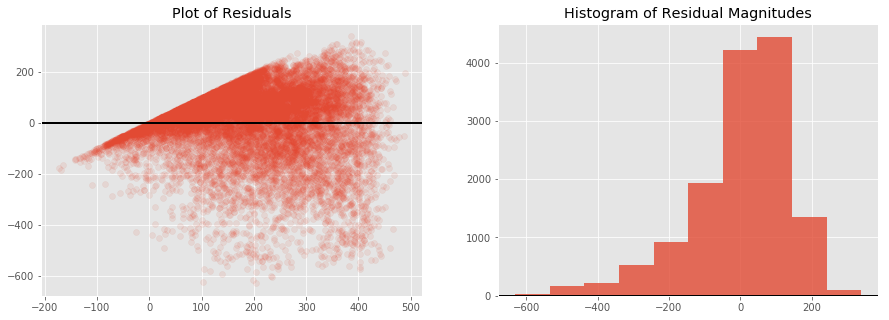

In [84]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, y_hat_train - Y_train[:,0], alpha=0.1)
axes[0].axhline(0, c='black', lw=2)

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(y_hat_train - Y_train[:,0], alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
plt.show()

We see that linear regression is a poor model for this data.  On the left, the variance of the residuals increases as y-hat increases, while there is also a pattern to the residuals (not uniform around zero) suggesting there is more than linear behavior needing to be modeled.

#### Implement forward step-wise selection to select a minimal subset of predictors

In [85]:
def step_forwards_backwards(df, response_var, direction='forward'):
    
    assert direction in ['forward', 'backward']
    
    y = df[response_var].values.reshape(-1,1)

    predictors = set(df.drop('counts', axis=1).columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = df.shape[0]
    best_bic = np.inf
    
    best_bics = []
    best_models = []
    
    if direction == 'forward':
        X = np.ones(n).reshape(-1,1)
        X = np.concatenate([X, df[list(selected_predictors)].values], axis=1)
        while (True):
            
            possible_bic_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            for predictor in possible_predictors:
                
                x_temp = np.concatenate([X, df[predictor].values.reshape(-1,1)], axis=1)
                model = OLS(endog=y, exog=x_temp).fit()
                bic = model.bic
                possible_bic_scores.append(bic)
                
            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            
            best_bic = np.min(possible_bic_scores)
            best_bics.append(best_bic)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, df[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))

    else:

        while (True):
            possible_bic_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break

            for predictor in possible_predictors:
                X = np.concatenate([np.ones(n).reshape(-1,1), 
                                    df[list(selected_predictors - set([predictor]))].values], axis=1)
                model = OLS(endog=y, exog=X).fit()
                bic = model.bic
                possible_bic_scores.append(bic)

            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix] 

            best_bic = possible_bic_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_bics.append(best_bic)
            best_models.append(list(selected_predictors))
            
    index_of_best_bic = np.argmin(best_bics)

    return best_models[index_of_best_bic]

In [86]:
predictors_forward = step_forwards_backwards(bikes_train, 'counts', direction='forward')
predictors_forward

['Snow',
 'Jul',
 'Jun',
 'year',
 'hour',
 'hum',
 'fall',
 'spring',
 'holiday',
 'temp',
 'Aug']

OR

In [87]:
predictors_backward = step_forwards_backwards(bikes_train, 'counts', direction='backward')
predictors_backward

['Snow',
 'Jun',
 'hour',
 'holiday',
 'Jul',
 'year',
 'hum',
 'fall',
 'spring',
 'temp',
 'Aug']

In [88]:
# the original set of predictiors
predictors = set(results.pvalues[((results.pvalues < 0.05) & (results.params > 0))].index).union(set(results.pvalues[((results.pvalues < 0.05) & (results.params < 0))].index))

print("Predictors removed by stepping backward:")

# the predictors removed by stepping backward
print(predictors.difference(set(predictors_backward)))

print("Predictors removed by stepping forward:")


# the predictors removed by stepping forward
print(predictors.difference(set(predictors_forward)))


Predictors removed by stepping backward:
{'summer', 'workingday', 'atemp', 'Apr', 'windspeed', 'May', 'Feb', 'Nov', 'Sat', 'const', 'Mar'}
Predictors removed by stepping forward:
{'summer', 'workingday', 'atemp', 'Apr', 'windspeed', 'May', 'Feb', 'Nov', 'Sat', 'const', 'Mar'}


<HR>

When fitting the linear model regression on the original dataset we found about 20 variables which were statistically significant.  With the stepping forward or backward, we are using only about half of those variables.  Whereas the fuller model might use holidays and working days, stepping forward or backward opted for one of the two.

Instead of keeping 6 months and 2 seasons, the reduced models keeps half as many months and seasonal designations.

Generally we can see here that stepping forward/backward appears to be removing redundancies.

<HR>

#### Fitting Multiple Regression Model on Subset of Predictors selected Forward and Backward Step-Wise Selection


In [89]:
X_forward = sm.add_constant(bikes_train[predictors_forward])
X_forward_test = sm.add_constant(bikes_test[predictors_forward])
y = bikes_train['counts'].values.reshape(-1,1)

model = OLS(endog=y, exog=X_forward)
result = model.fit()

y_hat_train = result.predict()
y_hat_test = result.predict(exog=X_forward_test)

print('train r2 = {:.4}'.format( r2_score(bikes_train['counts'], y_hat_train)))
print('test r2 = {:.4}'.format(r2_score(bikes_test['counts'], y_hat_test)))

train r2 = 0.4101
test r2 = 0.3777


<HR>

In the original full model, our $R^2$ was about .4127 on training set and 0.38 on test sets.  With the two restricted models, our $R^2$ values are only diminished by about .002.  It appears that in discarding extra features, we have not significantly diminished the predictive power of our model.

<HR>

#### Polynomial Regression

In order to improve the performance of the regression model, I will now be looking into how model performs when including higher-order polynomial and interaction terms

In [95]:
# Creating dataframe of higher order polynomials on a feature column up to order k
def gen_higher_order_features(df, feature_column, k):
    
    poly_model = PolynomialFeatures(k, include_bias=False)
    
    feature_data = df[feature_column]
    
    # transforming to get all the polynomial features of this column
    higher_orders = poly_model.fit_transform(feature_data.values.reshape(-1,1))
    
    feature_names = poly_model.get_feature_names([feature_column])

    return pd.DataFrame(higher_orders[:,1:], columns = feature_names[1:])

In [165]:
# defining all the continuous features 
continuous_columns = ['temp', 'atemp', 'hum', 'windspeed']

# generating higher order dfs -- use X_train_intercept and X_test_intercept since I'll be using OLS
higher_orders_train =[gen_higher_order_features(X_train, feature, 4) for feature in continuous_columns]
higher_orders_test = [gen_higher_order_features(X_test, feature, 4) for feature in continuous_columns]

higher_orders_train = pd.concat(higher_orders_train, axis=1)
higher_orders_test = pd.concat(higher_orders_test, axis=1)

higher_orders_columns = higher_orders_train.columns

# scale higher order polynomial features
scaler = preprocessing.StandardScaler().fit(higher_orders_train)

higher_orders_train[higher_orders_columns] = scaler.transform(higher_orders_train)
higher_orders_test[higher_orders_columns] = scaler.transform(higher_orders_test)

X_train = X_train.reset_index().drop(['index'], axis = 1)
X_test = X_test.reset_index().drop(['index'], axis = 1)

# concatenating to get the full data frames
X_poly_train = pd.concat([X_train, higher_orders_train], axis=1).drop(['level_0'], axis =1)
X_poly_test = pd.concat([X_test, higher_orders_test], axis=1)

In [166]:
model_poly = OLS(endog=Y_train, exog=X_poly_train).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     247.8
Date:                Sat, 23 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:30:22   Log-Likelihood:                -88241.
No. Observations:               13903   AIC:                         1.766e+05
Df Residuals:                   13860   BIC:                         1.769e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -772.2921    198.797     -3.885      0.000   -1161.962    -382.622
hour            7.2013      0.185     38.948      0.000       6.839       7.564
holiday       -23.9359      6.717     -3.563      0.000     -37.103     -10.769
year           81.9478      2.402     34.123      0.000      77.240      86.655
workingday      9.8748      2.756      3.583      0.000       4.472      15.278
temp         -265.7613    494.855     -0.537      0.591   -1235.743     704.220
atemp        1032.8242    569.604      1.813      0.070     -83.677    2149.326
hum           748.4047    239.172      3.129      0.002     279.595    1217.214
windspeed     -28.8913     73.553     -0.393      0.694    -173.065     115.282
spring         42.9002      7.424      5.778      0.000      28.347      57.453
summer         14.4380      8.816      1.638      0.102      -2.842      31.718
fall           63.5079      7.481      8.489      0.000      48.843      78.172
Feb             5.7802      6.128      0.943      0.346      -6.232      17.793
Mar            11.3915      6.937      1.642      0.101      -2.206      24.988
Apr           -20.5688     10.107     -2.035      0.042     -40.380      -0.758
May           -28.6905     10.690     -2.684      0.007     -49.645      -7.736
Jun           -74.9571     10.827     -6.923      0.000     -96.179     -53.735
Jul           -90.5574     12.166     -7.443      0.000    -114.405     -66.710
Aug           -60.5864     12.004     -5.047      0.000     -84.117     -37.056
Sept           -1.0021     10.838     -0.092      0.926     -22.247      20.243
Oct            13.5464     10.109      1.340      0.180      -6.268      33.361
Nov             2.0475      9.760      0.210      0.834     -17.084      21.179
Dec            11.7599      7.805      1.507      0.132      -3.538      27.058
Mon            -6.9242      2.969     -2.332      0.020     -12.744      -1.105
Tue            -3.5915      3.218     -1.116      0.264      -9.900       2.717
Wed            -0.5913      3.193     -0.185      0.853      -6.851       5.668
Thu            -4.7400      3.189     -1.486      0.137     -10.991       1.511
Fri             1.7860      3.173      0.563      0.574      -4.434       8.006
Sat            11.2636      4.375      2.574      0.010       2.688      19.839
Cloudy          6.0793      2.883      2.109      0.035       0.428      11.730
Snow          -21.3844      5.021     -4.259      0.000     -31.227     -11.542
Storm          36.0771     80.058      0.451      0.652    -120.848     193.002
temp^2       -544.1720    332.811     -1.635      0.102   -1196.527     108.183
temp^3       1229.6119    396.795      3.099      0.002     451.840    2007.384
temp^4       -604.4161    158.227     -3.820      0.000    -914.562    -294.270
atemp^2      -132.5221    333.019     -0.39

In [167]:
y_hat_train_poly = model_poly.predict()
y_hat_test_poly = model_poly.predict(exog=X_poly_test)
print('In-sample R^2 of polynomial features model is: {:.4}'.format(r2_score(Y_train, y_hat_train_poly)))
print('Out-of-sample R^2 of polynomial features model is: {:.4}'.format(r2_score(Y_test, y_hat_test_poly)))

In-sample R^2 of polynomial features model is: 0.4289
Out-of-sample R^2 of polynomial features model is: 0.3922


<HR>

Again, the $R^2$ for the original model was about .406 on training set and test sets.  For our poly-model, the $R^2$ values have increased to around .4289 for the training and test sets.  This represents a pretty good improvement in model performance.

<HR>

In [168]:
print("Statistically significant predictors: ", 
      list(model_poly.params[model_poly.pvalues < 0.05].keys()))

Statistically significant predictors:  ['const', 'hour', 'holiday', 'year', 'workingday', 'hum', 'spring', 'fall', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Mon', 'Sat', 'Cloudy', 'Snow', 'temp^3', 'temp^4', 'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3', 'windspeed^4']


<HR>
Looking at the linear regression models, temperature, weather severity, humidity, and time of day appear to be the driving forces in modeling counts.  

All of the models we calculated run about the same in terms of $R^2$.  For the best result, using the polymodel with up to quadratic terms gives the best regression.  There is no reason to assume that the continuous variables should have a strictly linear effect, particularly as hour of the day should have positive impact at the middle of the day, and negative impact at the ends of the day (this was borne out by the regression and statistically significant variables).  Consequently, I would opt for the polynomial model in forecasting bike share usage.

Noting that ridership is diminished in the winter, in a statistically siginificant way, heated seats or handlebar mounted gloves might help casual riders overcome the cold, particularly on days that are cold, but otherwise good weather.

In the winter when the temperature is low, discounts may help increase ridership, but in the warmer months, there is greater variance to ridership, and a higher mean ridership.  Offering a discount on a high humidity day may exploit the inherently higher variance and mean to give a more significant boost in ridership.

It would be worth to further explore and predict registered or casual counts separately: the two features function in very distinct ways, and trying to predict their relative counts without intermingling allows for much greater correlation with fewer variables.

<HR>



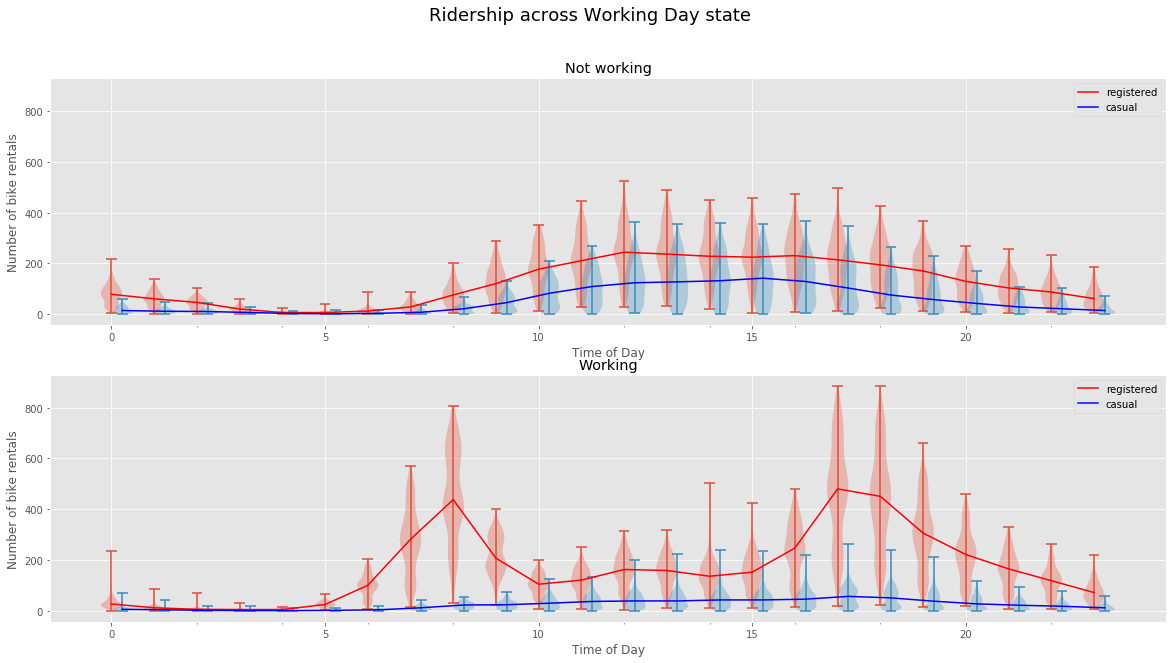

In [169]:

fig, ax = plt.subplots(2,1, figsize=(20,10), sharey=True)
ax = ax.ravel()

working_strings = ["Not working","Working"]
for working in [0,1]:
    cur_ax = ax[working]
    cur_working_string = working_strings[working]

    bikes_df_working = bikes_df[((bikes_df.workingday == working) & (bikes_df.holiday != 1))]


    reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df_working)
    reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
    cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)

    reg_hourly_data_median= [np.median(q) for q in reg_hourly_data]
    cas_hourly_data_median= [np.median(q) for q in cas_hourly_data]

    cur_ax.plot(reg_hourly_data_median, 'r', label="registered")
    cur_ax.plot(np.arange(24)+.25,cas_hourly_data_median, 'b', label="casual")
    
    cur_ax.legend()

    cur_ax.set_xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
    cur_ax.set_ylabel('Number of bike rentals')
    cur_ax.set_xlabel('Time of Day')
    cur_ax.set_title(working_strings[working])

plt.suptitle("Ridership across Working Day state",fontsize = 18)
plt.show()

<HR>

The working day counts for registered riders appears bimodal.  This seems to contribute to a high mean and high variance for registered riders during the working week.  Given that registered rider count is high and registered ridership on working days is also high variance, sporadic discounts on working days to try to select for the higher mode may be particularly effective for boosting business.

<HR>

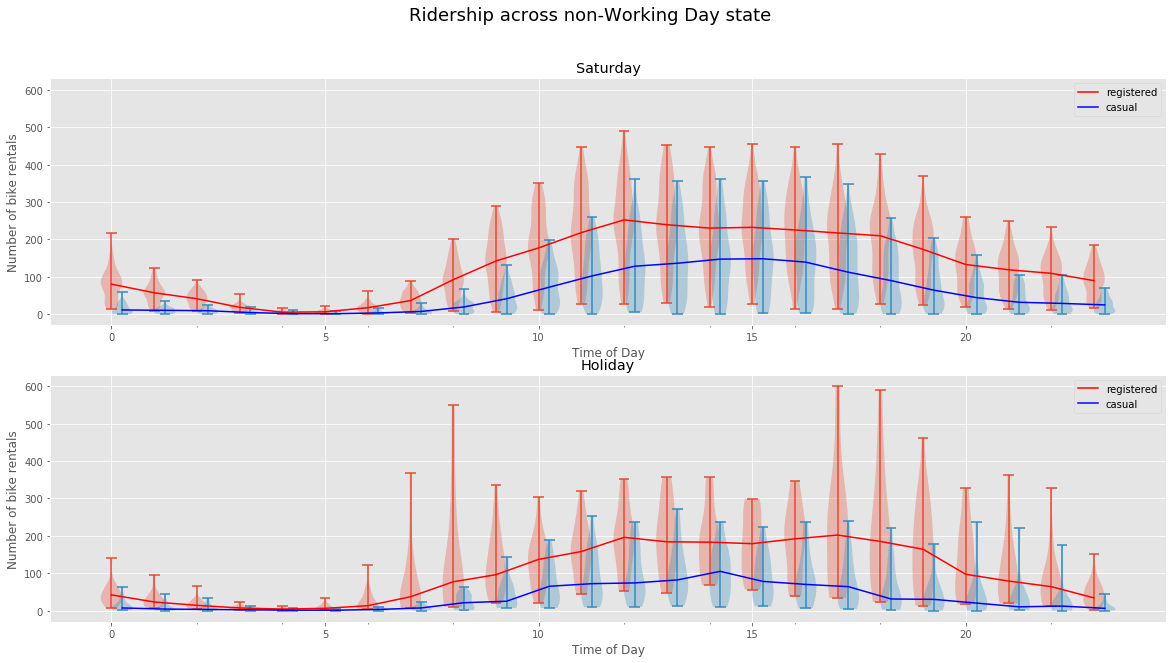

In [170]:
fig, ax = plt.subplots(2,1, figsize=(20,10), sharey=True)
ax = ax.ravel()

# Saturday data
cur_ax = ax[0]

bikes_df_sub = bikes_df[((bikes_df.Sat == 1))]

reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df_sub)
reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)

reg_hourly_data_median= [np.median(q) for q in reg_hourly_data]
cas_hourly_data_median= [np.median(q) for q in cas_hourly_data]

cur_ax.plot(reg_hourly_data_median, 'r', label="registered")
cur_ax.plot(np.arange(24)+.25,cas_hourly_data_median, 'b', label="casual")

cur_ax.legend()

cur_ax.set_xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
cur_ax.set_ylabel('Number of bike rentals')
cur_ax.set_xlabel('Time of Day')
cur_ax.set_title("Saturday")


# Holiday data
cur_ax = ax[1]

bikes_df_sub = bikes_df[((bikes_df.holiday == 1))]

reg_hourly_data,cas_hourly_data = get_hourly_violin_lists(bikes_df_sub)
reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24),)
cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)

reg_hourly_data_median= [np.median(q) for q in reg_hourly_data]
cas_hourly_data_median= [np.median(q) for q in cas_hourly_data]

cur_ax.plot(reg_hourly_data_median, 'r', label="registered")
cur_ax.plot(np.arange(24)+.25,cas_hourly_data_median, 'b', label="casual")

cur_ax.legend()

cur_ax.set_xticks(list(ticks_dict.keys()), list(ticks_dict.values()))
cur_ax.set_ylabel('Number of bike rentals')
cur_ax.set_xlabel('Time of Day')
cur_ax.set_title("Holiday")

plt.suptitle("Ridership across non-Working Day state",fontsize = 18)
plt.show()

<HR>

On weekends, registered riders appear to function similarly to casual riders, but on holidays, registered riders appear to function differently than their casual counterparts.  They appear to reduce in numbers, but follow distributions as if it was a working day with errands and chores.  A possible discount on holidays might keep the registered numbers from taking a full day off and not renting a bike.

<HR>